[![PALS0039 Logo](https://www.phon.ucl.ac.uk/courses/pals0039/images/pals0039logo.png)](https://www.phon.ucl.ac.uk/courses/pals0039/)

# Exercise 6.1 Sentiment Analysis from text using RNNs

In this exercise we revisit the [Internet Movie Database](https://www.imdb.com/) Sentiment Analysis task from exercise 4.1. But this time exploiting GloVe word embeddings and a recurrent network for classification.

Recall that Words in the reviews have already been tokenised and encoded as numbers using a dictionary and are labelled as positive or negative. We load the numeric sequences as variable length lists then do the following:

1. Map each to their GloVe representation
2. Train a RNN to map each sequence directly to the classification result (no mapping to fixed-length vectors using bag-of-words)


Run the following code block which loads the pre-prepared dataset from the Keras package (as in Ex. 4.1).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, Flatten, SimpleRNN, LSTM, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb

# Load the dataset with a 10,000 word vocabulary
(Xtrain_seq, ytrain), (Xtest_seq, ytest) = imdb.load_data(num_words=10000, index_from=2)

# Print out a sample (first few inputs and associated outputs) of the data
print("SAMPLE OF THE DATA:")
print("-------------------")
print("INPUTS:")
print(Xtrain_seq[:3])
print("OUTPUTS:")
print(ytrain[:3])


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
SAMPLE OF THE DATA:
-------------------
INPUTS:
[list([1, 13, 21, 15, 42, 529, 972, 1621, 1384, 64, 457, 4467, 65, 3940, 3, 172, 35, 255, 4, 24, 99, 42, 837, 111, 49, 669, 2, 8, 34, 479, 283, 4, 149, 3, 171, 111, 166, 2, 335, 384, 38, 3, 171, 4535, 1110, 16, 545, 37, 12, 446, 3, 191, 49, 15, 5, 146, 2024, 18, 13, 21, 3, 1919, 4612, 468, 3, 21, 70, 86, 11, 15, 42, 529, 37, 75, 14, 12, 1246, 3, 21, 16, 514, 16, 11, 15, 625, 17, 2, 4, 61, 385, 11, 7, 315, 7, 105, 4, 3, 2222, 5243, 15, 479, 65, 3784, 32, 3, 129, 11, 15, 37, 618, 4, 24, 123, 50, 35, 134, 47, 24, 1414, 32, 5, 21, 11, 214, 27, 76, 51, 4, 13, 406, 15, 81, 2, 7, 3, 106, 116, 5951, 14, 255, 3, 2, 6, 3765, 4, 722, 35, 70, 42, 529, 475, 25, 399, 316, 45, 6, 3, 2, 1028, 12, 103, 87, 3, 380, 14, 296, 97, 31, 2070, 55, 25, 140, 5, 193, 7485, 17, 3, 225, 21, 20, 133, 475, 25, 479, 4, 143, 29, 5534, 17, 50, 35, 27, 223, 91, 24, 103, 3, 225, 64, 15, 37, 1333, 87, 11, 15, 282, 4, 15, 447

---
(a) Confirm the highest term index occuring in our dataset?

In [2]:
#(a)
highest_index_per_document = []
for document in Xtrain_seq:
  highest_index_per_document.append(max(document))
highest_term_index = max(highest_index_per_document)
print("Highest index in the dataset:", highest_term_index)

Highest index in the dataset: 9999


---
(b) Collect all the document lengths in a list and determine the longest review (in either the train or test sets), how many words?

In [3]:
from itertools import chain

document_lengths = []
#(b)
combined_docs = list(chain(Xtrain_seq, Xtest_seq))
for it in combined_docs:
  document_lengths.append(len(it))

print(max(document_lengths))



2494


---
Load the Glove embeddings and set the first column as the dataframe index so that we can look up vectors by word (instead of row number):

In [4]:
glove = pd.read_csv("https://www.phon.ucl.ac.uk/courses/pals0039/data/exercise_05/glove.6B.100d.zip", header=None)
# Set the word column as index:
glove.set_index(0, inplace=True)

print(f"Read {len(glove)} word embeddings of length {len(glove.columns)}:")
print("------------------------------------------------------------------")
glove

Read 400000 word embeddings of length 100:
------------------------------------------------------------------


,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,,,,,,,,,,,,,,,,,,,,,
the,-0.038194,-0.244870,0.728120,-0.399610,0.083172,0.043953,-0.391410,0.334400,-0.57545,0.087459,...,0.016215,-0.017099,-0.389840,0.87424,-0.725690,-0.510580,-0.520280,-0.145900,0.82780,0.270620
",",-0.107670,0.110530,0.598120,-0.543610,0.673960,0.106630,0.038867,0.354810,0.06351,-0.094189,...,0.349510,-0.722600,0.375490,0.44410,-0.990590,0.612140,-0.351110,-0.831550,0.45293,0.082577
.,-0.339790,0.209410,0.463480,-0.647920,-0.383770,0.038034,0.171270,0.159780,0.46619,-0.019169,...,-0.063351,-0.674120,-0.068895,0.53604,-0.877730,0.318020,-0.392420,-0.233940,0.47298,-0.028803
of,-0.152900,-0.242790,0.898370,0.169960,0.535160,0.487840,-0.588260,-0.179820,-1.35810,0.425410,...,0.187120,-0.018488,-0.267570,0.72700,-0.593630,-0.348390,-0.560940,-0.591000,1.00390,0.206640
to,-0.189700,0.050024,0.190840,-0.049184,-0.089737,0.210060,-0.549520,0.098377,-0.20135,0.342410,...,-0.131340,0.058617,-0.318690,-0.61419,-0.623930,-0.415480,-0.038175,-0.398040,0.47647,-0.159830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chanty,-0.155770,-0.049188,-0.064377,0.223600,-0.201460,-0.038963,0.129710,-0.294510,0.00359,-0.098377,...,0.093324,0.094486,-0.023469,-0.48099,0.623320,0.024318,-0.275870,0.075044,-0.56380,0.145010
kronik,-0.094426,0.147250,-0.157390,0.071966,-0.298450,0.039432,0.021870,0.008041,-0.18682,-0.311010,...,-0.305450,-0.011082,0.118550,-0.11312,0.339510,-0.224490,0.257430,0.631430,-0.20090,-0.105420
rolonda,0.360880,-0.169190,-0.327040,0.098332,-0.429700,-0.188740,0.455560,0.285290,0.30340,-0.366830,...,-0.044082,0.140030,0.300070,-0.12731,-0.143040,-0.069396,0.281600,0.271390,-0.29188,0.161090


---
The following code retrieves the mapping terms -> indices (starting from 1) from the IMDB corpus and uses this to create an inverse mapping (indices -> terms) taking care to map the special symbols we have introduced with `load_data` and any other terms that are not in GloVe to entries that are defined in GloVe.

In [6]:
import tensorflow as tf
device = "CPU"
if tf.config.list_physical_devices('GPU'):
    device = "GPU"
print(f"Using {device} device")

term_to_index = imdb.get_word_index()

# We map both 0 and 1 (PAD and START) to "." and
# 2 (OOV) and other out-of-vocabulary entries to ","
# (which are in the GloVe vocabulary):
index_to_term = {0: ".", 1: ".", 2: ","}
for term, index in term_to_index.items():
  if term in glove.index:
    index_to_term[index + 2] = term
  else:
    index_to_term[index + 2] = ","

# Print out the mappings to the special symbols and the top 10 most frequent words therafter
for i in range(13):
  print(i, index_to_term[i], sep="\t")

Using GPU device
0	.
1	.
2	,
3	the
4	and
5	a
6	of
7	to
8	is
9	br
10	in
11	it
12	i


---
(c) Use the index -> term mapping created above to convert the first document to a human-readable version for inspection.

In [7]:
#(c)
first_document = Xtrain_seq[0]
for term_index in first_document:
  term = index_to_term[term_index]
  print(term, end=" ")

. this film was just brilliant casting location scenery story direction , really suited the part they played and you could just imagine being there robert , is an amazing actor and now the same being director , father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for , and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also , to the two little , that played the , of norman and paul they were just brilliant children are often left out of the , list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done , you think the whole stor

---
Determine the maximum length of a document and either truncate or "pad" sequences that are longer or shorter respectively:

In [8]:
# Determine a maximum document length so that 95%
# of documents will not need to be truncated ~600 words:
maximum_document_length = int(np.percentile(document_lengths, 95))

# truncate and pad the sequences with zeros at the start
Xtrain_pad = pad_sequences(Xtrain_seq, maxlen=maximum_document_length, padding="pre", value=0)
Xtest_pad = pad_sequences(Xtest_seq, maxlen=maximum_document_length, padding="pre", value=0)

# print the size of the training data and some sample values
print(Xtrain_pad.shape)
print(Xtrain_pad[:5,])

(25000, 598)
[[   0    0    0 ...   18  177   31]
 [   0    0    0 ...   15  144   94]
 [   0    0    0 ...    6  128  112]
 [   0    0    0 ...   20   63 2573]
 [   0    0    0 ...    6   60  112]]


---
Create a numpy array to hold the embeddings for the IMDB words in the correct order; each row in the array has an index that corresponds with the IMDB numerical representation:

In [9]:
import tensorflow as tf
device = "CPU"
if tf.config.list_physical_devices('GPU'):
    device = "GPU"
print(f"Using {device} device")

# build an array to hold the embeddings for every IMDB word
word_embed = np.zeros((10000, glove.shape[1]))

# copy embeddings into the array at the correct indices
for i in range(10000):
  word_embed[i] = glove.loc[index_to_term[i]]

# Perform some sanity checks:
for term in ["the", "car"]:
  glv_emb = glove.loc[term]
  wrd_emb = word_embed[term_to_index[term] + 2]
  print(f"Term '{term}' corresponds:", np.allclose(glv_emb, wrd_emb))


Using GPU device
Term 'the' corresponds: True
Term 'car' corresponds: True


---
(d) Build a model with embeddings in the first layer. Look up the [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/) and [Embedding](https://keras.io/api/layers/core_layers/embedding/) constructors in the Keras documentation and add comments to explain the arguments.

In [ ]:
'''
Initial model:
TRAIN SET ACCURACY:	0.902679979801178
TEST SET ACCURACY:	0.8759599924087524

Changing the number of LSTM nodes
64 nodes:
TRAIN SET ACCURACY:	0.9309999942779541
TEST SET ACCURACY:	0.8755199909210205
= More overfitting

Changing the dropout rate
Dropout rate: 0.4
TRAIN SET ACCURACY:	0.89055997133255
TEST SET ACCURACY:	0.8713200092315674
= No significant improvement

Dropout rate: 0.3
TRAIN SET ACCURACY:	0.8889200091362
TEST SET ACCURACY:	0.8672800064086914
= Could more training lead to higher accuracy?

Changing the activation function in the LSTM
tanh:
TRAIN SET ACCURACY:	0.8743600249290466
TEST SET ACCURACY:	0.859359979629516

Adding a second LSTM layer
TRAIN SET ACCURACY:
TEST SET ACCURACY:

Changing to a bi-directional LSTM layer
TRAIN SET ACCURACY:
TEST SET ACCURACY:
'''

In [32]:
def build_model(hidden_width=32, dropout_rate=0.2):
  model = Sequential()
  #(d)
  # Embedding (class): turns nonnegative integers (indexes) into dense vectors of fixed size
  # e.g. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]
  model.add(Embedding(10000, word_embed.shape[1], weights=[word_embed], input_length=maximum_document_length, trainable=False))
  # LSTM (class): layer will choose different implementations (cuDNN-based or backend-native) to maximize the performance
  model.add(LSTM(hidden_width, return_sequences=True, dropout=dropout_rate))
  model.add(LSTM(hidden_width, return_sequences=False, dropout=dropout_rate))
  model.add(Dense(1, activation='tanh'))
  model.compile(loss='binary_crossentropy', optimizer="rmsprop", metrics=['accuracy'])
  return model

model = build_model()
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

---
(e) Call the [`model.fit` method](https://keras.io/api/models/model_training_apis/#fit-method) with the correct arguments to train the model with the following specifications: (1) Train for 30 iterations over the dataset; (2) Update the weights during training in batches of 64 samples; (3) Request Keras to randomly select 10% of the training set as the **validation set**.

In [ ]:
#(e)
# The following few lines check whether a GPU is available, and if so,
# they run everything on a GPU which will be much faster.
import tensorflow as tf
device = "CPU"
if tf.config.list_physical_devices('GPU'):
    device = "GPU"
print(f"Using {device} device")

training_info = model.fit(Xtrain_pad, ytrain, epochs=30, batch_size=64, validation_split=0.10, verbose=0)

Using GPU device


---
Plot and examine the training graphs, compare the training and evaluation errors. Run the code.

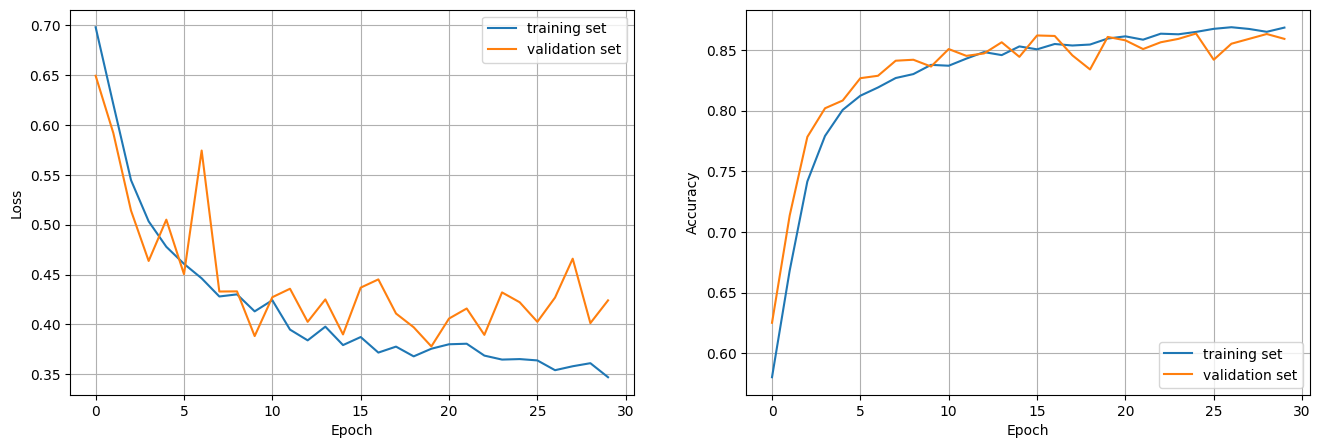

In [27]:
def plot_training_history(training_info):
  # Plot the training process:
  fig, axs = plt.subplots(1, 2, figsize=(16, 5))
  axs[0].plot(training_info.history['loss'], label="training set")
  axs[0].plot(training_info.history['val_loss'], label="validation set")
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("Loss")
  axs[0].grid(True)
  axs[0].legend()
  try:
    axs[1].plot(training_info.history['accuracy'], label="training set")
    axs[1].plot(training_info.history['val_accuracy'], label="validation set")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].grid(True)
    axs[1].legend()
  except:
    pass
  plt.show()

plot_training_history(training_info)

(f) Does the process exhibit overfitting or underfitting?

In [18]:
#(f)
# The process exhibits slight overfitting, as we can see that the validation set is beginnning to decrease, and the training set is yielding a very high accuracy.
# This would have been problematic if we continued training for longer.

---
(g) Estimate the generalisation performance of the model on the test set (use the [`model.evaluate` method](https://keras.io/api/models/model_training_apis/#evaluate-method)). How does the test accuracy compare to those in Exercise 4.1.

In [29]:
#(g)
# Calling model.evaluate method on model
train_loss, train_accuracy = model.evaluate(Xtrain_pad, ytrain, verbose=0)
test_loss, test_accuracy = model.evaluate(Xtest_pad, ytest, verbose=0)

print("TRAIN SET ACCURACY:", train_accuracy, sep="\t")
print("TEST SET ACCURACY:", test_accuracy, sep="\t")

TRAIN SET ACCURACY:	0.8743600249290466
TEST SET ACCURACY:	0.8593599796295166


---
(h) **Optional:** Experiment with the network architecture and training protocol for this problem. For example you might try:
- Changing the number of LSTM nodes
- Changing the dropout rate
- Changing the activation function in the LSTM
- Adding a second LSTM layer
- Changing to a bi-directional LSTM layer

What is the best result you can get?